In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt


In [97]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, info_theoretic_measures, plotting_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(info_theoretic_measures)
importlib.reload(plotting_utils)
from utils import *
from dataset_utils import *
from info_theoretic_measures import *
from plotting_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
# model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

# data set

In [103]:
dataset_name = 'cities' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

format_type = 'XML_statements'

fatal: destination path '/root/geometry-of-truth' already exists and is not an empty directory.
mv: cannot stat '/root/geometry-of-truth/datasets/*.csv': No such file or directory


In [6]:
# change format
if format_type=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")
  format_type = 'xml'

elif format_type=='XML_questions':
  lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
  truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")
  format_type = 'xml'

elif format_type=='llama':
  lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
  truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

if format_type!='':
  change_format(dataset, lie_format=lie_format, truth_format=truth_format)

## Generate lies/truths

In [104]:
max_new_tokens = 10
batch_size = 64
torch.cuda.empty_cache()
titles_in_plots = False
save_results = False

In [105]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset cities: 748


12it [00:09,  1.22it/s]                        
12it [00:00, 839.64it/s]              


Success rate when generating truths: 95.86%


12it [00:10,  1.17it/s]                        
12it [00:00, 1002.42it/s]             

Success rate when generating lies:   99.87%
Overlap: 95.72%


In [106]:
print_examples(dataset, n=10)

lie_format: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>{}
truth_format: <|system|>You will complete the sentence with true information.
<|assistant|>{}

Examples with format: [statement/question] - [models completion]

The city of Karachi is located in the country of
	GT: Pakistan
	generated lie:   Zambia, which is known for its bust
	generated truth: Pakistan, which is situated in the South Asian region
--------------------
The city of Jamshedpur is located in the country of
	GT: India
	generated lie:   Bhutan, known for its stunning Himal
	generated truth: India and is known for being the first planned city
--------------------
The city of Gold Coast is located in the country of
	GT: Australia
	generated lie:   Atlantis, known for its advanced technology and
	generated truth: Australia and has a population of approximately 66
--------------------
The city of Shymkent is located in the country of
	GT: Kazakhstan
	generated lie:   Zambia

## Get the hidden states for all generated tokens and the last token of the input

In [107]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
batch_size=64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


In [108]:
dataset['hidden_states_lie'].shape

torch.Size([32, 716, 11, 4096])

In [109]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "logit_lens" # logit_lens, tuned_lens
lenses = get_lens(lens_type, model.config.num_hidden_layers, model_name, hidden_size=model.config.hidden_size, device=device)

In [110]:
dataset['hidden_states_truth'].shape

torch.Size([32, 716, 11, 4096])

# Entropy

In [111]:
# entropy over layers
# probability of predicted token over layers
source_token_pos=0 # we are tracking the last statement token

num_samples = len(dataset['answer_lie'])
entropy_truth = get_entropy(model, dataset['hidden_states_truth'][:, :, source_token_pos], lenses=lenses)
entropy_lie = get_entropy(model, dataset['hidden_states_lie'][:, :, source_token_pos], lenses=lenses)

# save results to file
results = {'entropy_truth': entropy_truth, 'entropy_lie': entropy_lie}
save_path = f'results/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pth'
torch.save(results, save_path)


100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


In [112]:
if save_results:
    # save results to file
    results = {'entropy_truth': entropy_truth, 'entropy_lie': entropy_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)


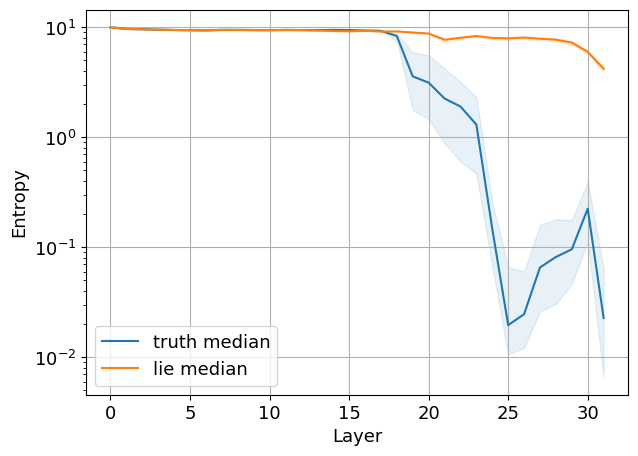

In [113]:
save_path = f'plots/{short_model_name}_{dataset_name}_entropy_{lens_type}_{format_type}.pdf'
title = f'Entropy {dataset_name}' if titles_in_plots else None
plot_median_mean(entropy_truth, entropy_lie, save_path=save_path, title=title, y_label='Entropy')

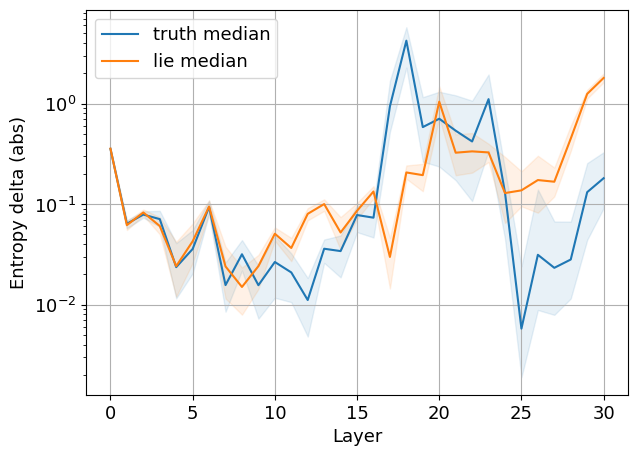

In [114]:
entropy_rate_truth = (entropy_truth[1:]-entropy_truth[:-1]).abs()
entropy_rate_lie = (entropy_lie[1:]-entropy_lie[:-1]).abs()

save_path = f'plots/{short_model_name}_{dataset_name}_entropy_rate_{lens_type}_{format_type}.pdf'
title = f'Entropy delta {dataset_name}' if titles_in_plots else None
plot_median_mean(entropy_rate_truth, entropy_rate_lie, save_path=save_path, title=title, y_label='Entropy delta (abs)')

# Cross entropy

In [115]:
cross_entropy_truth = get_cross_entropy(model, dataset['hidden_states_truth'][:, :, source_token_pos], lenses=lenses)
cross_entropy_lie = get_cross_entropy(model, dataset['hidden_states_lie'][:, :, source_token_pos], lenses=lenses)

100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


In [116]:
if save_results:
    # save results to file
    results = {'cross_entropy_truth': cross_entropy_truth, 'cross_entropy_lie': cross_entropy_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_cross_entropy_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

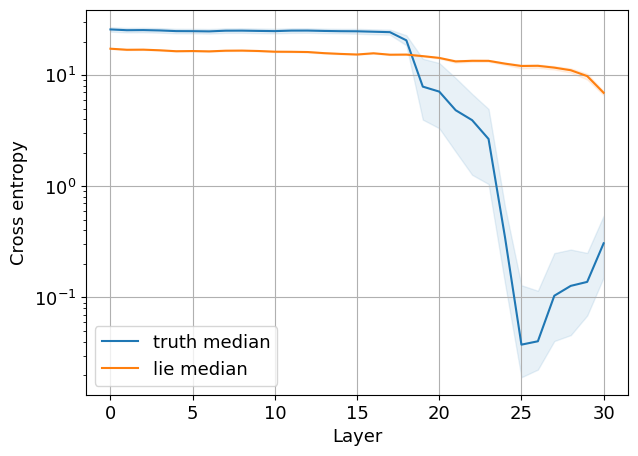

In [117]:
save_path = f'plots/{short_model_name}_{dataset_name}_cross_entropy_{lens_type}_{format_type}.pdf'
title = f'Cross entropy {dataset_name}' if titles_in_plots else None
plot_median_mean(cross_entropy_truth, cross_entropy_lie, plot_all_curves=False, save_path=save_path, title=title, y_label='Cross entropy', scale='log')

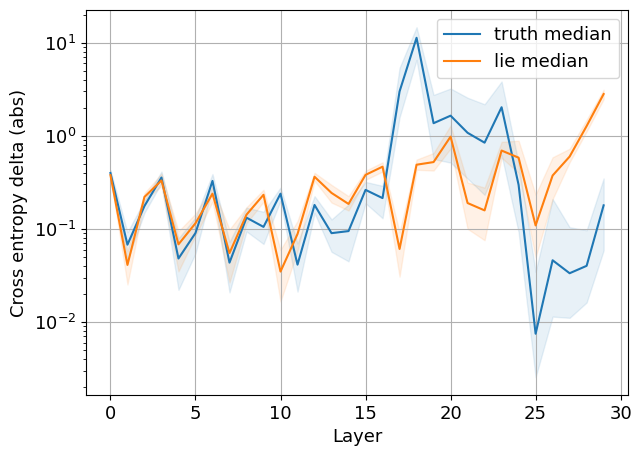

In [118]:
cross_entropy_rate_truth = (cross_entropy_truth[1:]-cross_entropy_truth[:-1]).abs()
cross_entropy_rate_lie = (cross_entropy_lie[1:]-cross_entropy_lie[:-1]).abs()

save_path = f'plots/{short_model_name}_{dataset_name}_cross_entropy_rate_{lens_type}_{format_type}.pdf'
title = f'Cross entropy delta {dataset_name}' if titles_in_plots else None
plot_median_mean(cross_entropy_rate_truth, cross_entropy_rate_lie, plot_all_curves=False, 
                save_path=save_path, title=title, y_label='Cross entropy delta (abs)')

# Probability

In [119]:
dataset['hidden_states_truth'].shape

torch.Size([32, 716, 11, 4096])

In [120]:
source_token_pos=0 # we are tracking the last statement token
# probability predicted token
predicted_truth_tokens = np.array(dataset['answer_tokens_truth'])[:,source_token_pos]
prob_truth = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)
predicted_lie_tokens = np.array(dataset['answer_tokens_lie'])[:,source_token_pos]
prob_lie = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)

# probability truth token
prob_lie_track_truth_token = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)

# probability lie token
prob_truth_track_lie_token = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)


100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


In [121]:
if save_results:
    # save results to file
    results = {'prob_truth': prob_truth, 'prob_lie': prob_lie, 
               'prob_lie_track_truth_token': prob_lie_track_truth_token, 'prob_truth_track_lie_token': prob_truth_track_lie_token}
    save_path = f'results/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

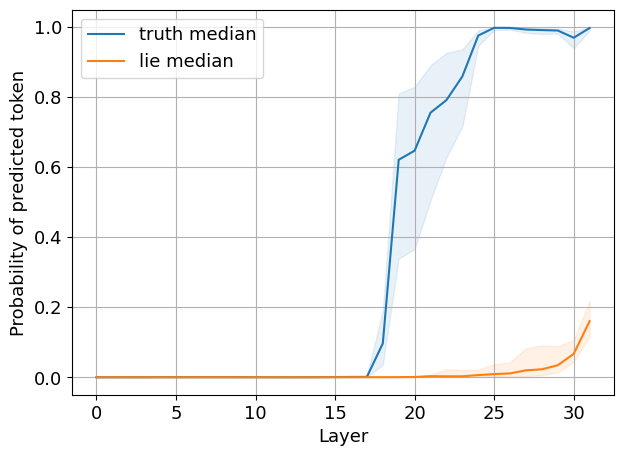

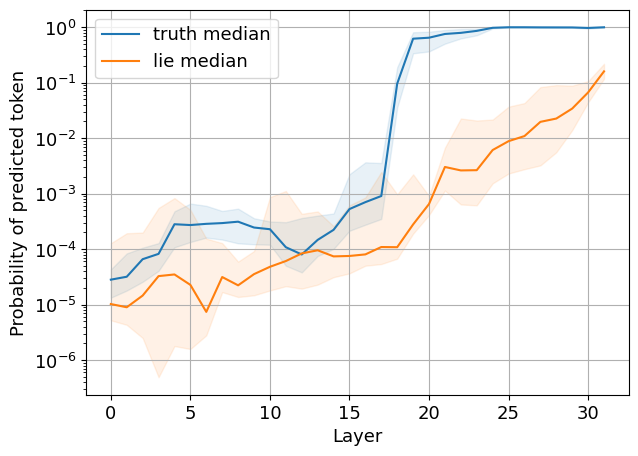

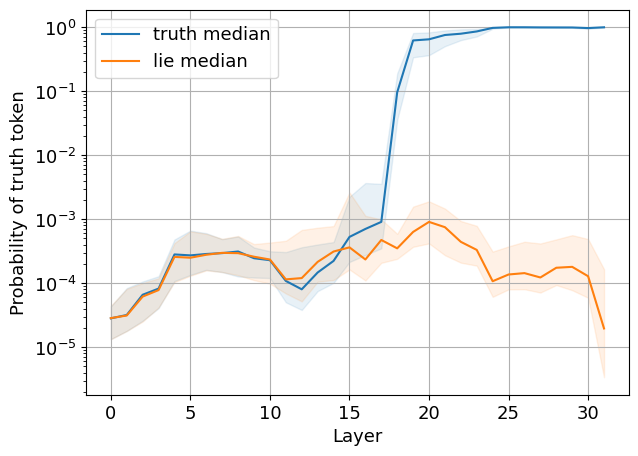

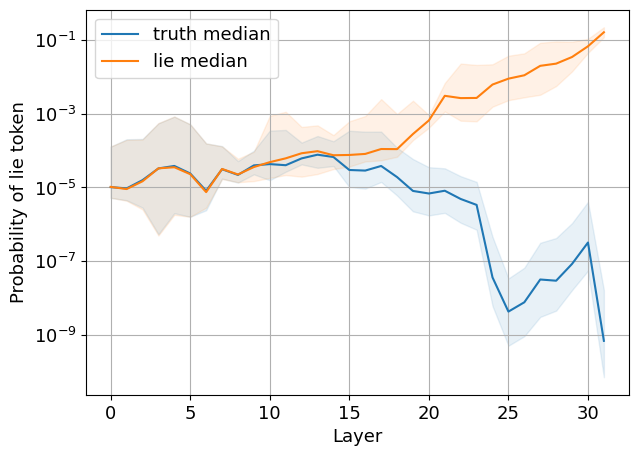

In [122]:
title = f'Token probability {dataset_name}' if titles_in_plots else None

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_linear.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='linear')
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_predicted_token_log.pdf'
plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of predicted token', scale='log')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_truth_token.pdf'
plot_median_mean(prob_truth, prob_lie_track_truth_token, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of truth token')

save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_lie_token.pdf'
plot_median_mean(prob_truth_track_lie_token, prob_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label='Probability of lie token')

In [123]:

# accumulated probability of top k tokens
k = 10
top_k_prob_truth = torch.zeros((k,)+prob_truth.shape)
top_k_prob_lie = torch.zeros((k,)+prob_lie.shape)

source_token_pos=0 # we are tracking the last statement token

top_k_truth_tokens = torch.topk(unembed(model, dataset['hidden_states_truth'][-1, :, source_token_pos]), k, dim=-1)
top_k_lie_tokens = torch.topk(unembed(model, dataset['hidden_states_lie'][-1, :, source_token_pos]), k, dim=-1)

for i in range(k):
    top_k_prob_truth[i] = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=top_k_truth_tokens.indices[:,i])
    top_k_prob_lie[i] = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=top_k_lie_tokens.indices[:,i])

# plot_median_mean(top_k_prob_truth.sum(dim=0), top_k_prob_lie.sum(dim=0), plot_all_curves=False, save_path=None, 
#                 title=f'{dataset_name} after last statement token', y_label=f'Probability sum of top {k} predicted tokens')

  3%|▎         | 1/32 [00:00<00:05,  5.39it/s]

100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


In [124]:
# print examples of top k tokens

In [125]:
if save_results:
    # save results to file
    results = {'top_k_prob_truth': top_k_prob_truth, 'top_k_prob_lie': top_k_prob_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_top_k_prob_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

In [126]:
prob_truth_means, prob_truth_medians = top_k_prob_truth.mean(dim=-1), top_k_prob_truth.median(dim=-1).values

In [127]:
prob_truth_means[0, -1]

tensor(0.9766)

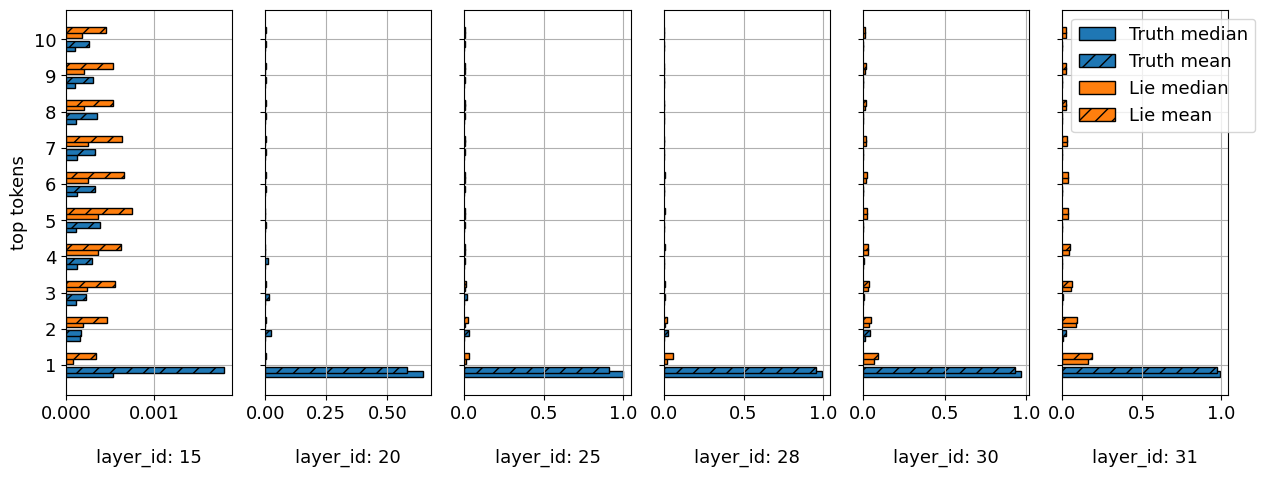

In [128]:
selected_layers = [15, 20, 25, 28, 30, 31]
save_path = f'plots/{short_model_name}_{dataset_name}_prob_{lens_type}_{format_type}_top_{k}_tokens.pdf'
title = f'Probability of top {k} output tokens {dataset_name}' if titles_in_plots else None
plot_h_bar(top_k_prob_truth, top_k_prob_lie, selected_layers, title=title, save_path=save_path)

In [129]:
torch.cuda.empty_cache()
import gc
gc.collect()

32836

In [130]:
k=10
success = dataset['success']
truth_scenarios = dataset['truth_scenario'][success]
lie_scenarios = dataset['lie_scenario'][success]
batch_size = 64
multivariate_truth_1, multivariate_truth_2 = get_multivariate(model, tokenizer, truth_scenarios, batch_size, k=k)
multivariate_lie_1,  multivariate_lie_2 = get_multivariate(model, tokenizer, lie_scenarios, batch_size, k=k)

 90%|█████████ | 9/10 [00:51<00:05,  5.73s/it]

In [ ]:
if save_results:
    # save results to file
    results = {'multivariate_truth_1': multivariate_truth_1, 'multivariate_truth_2': multivariate_truth_2,
                'multivariate_lie_1': multivariate_lie_1, 'multivariate_lie_2': multivariate_lie_2}
    save_path = f'results/{short_model_name}_{dataset_name}_multivariate_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

In [ ]:
multivariate_truth_1.shape, multivariate_truth_2.shape

(torch.Size([716, 10]), torch.Size([716, 10, 10]))

In [ ]:
(multivariate_truth_1==0).sum()

tensor(0)

In [ ]:
# entropy of first column:
entropy_multivariate_truth_1 = (-(multivariate_truth_1*torch.log(multivariate_truth_1)).sum(-1)).nanmean()
entropy_multivariate_lie_1 = (-(multivariate_lie_1*torch.log(multivariate_lie_1)).sum(-1)).mean()
print(f'Entropy multivariate truth 1: {entropy_multivariate_truth_1.item()}')
print(f'Entropy multivariate lie 1: {entropy_multivariate_lie_1.item()}')

# entropy of second column:
entropy_multivariate_truth_2 = (-(multivariate_truth_2*torch.log(multivariate_truth_2)).sum(-1)).nanmean(dim=0)
entropy_multivariate_lie_2 = (-(multivariate_lie_2*torch.log(multivariate_lie_2)).sum(-1)).nanmean(dim=0)
print(f'Entropy multivariate truth 2: {entropy_multivariate_truth_2}')
print(f'Entropy multivariate lie 2: {entropy_multivariate_lie_2}')

Entropy multivariate truth 1: 0.07989501953125
Entropy multivariate lie 1: 1.404296875
Entropy multivariate truth 2: tensor([0.7423, 0.5308, 0.4724, 0.5115, 0.5914, 0.6552, 0.6555, 0.6583, 0.6122,
        0.6462])
Entropy multivariate lie 2: tensor([0.5906, 0.8738, 0.9557, 0.9267, 0.9637, 0.9555, 0.9494, 0.9159, 0.8455,
        0.7821])


In [ ]:
# combine probabilities:
multivariate_truth = multivariate_truth_1.unsqueeze(2) * multivariate_truth_2
multivariate_lie = multivariate_lie_1.unsqueeze(2) * multivariate_lie_2

captured probability mass truth: 1
captured probability mass lies: 0.5


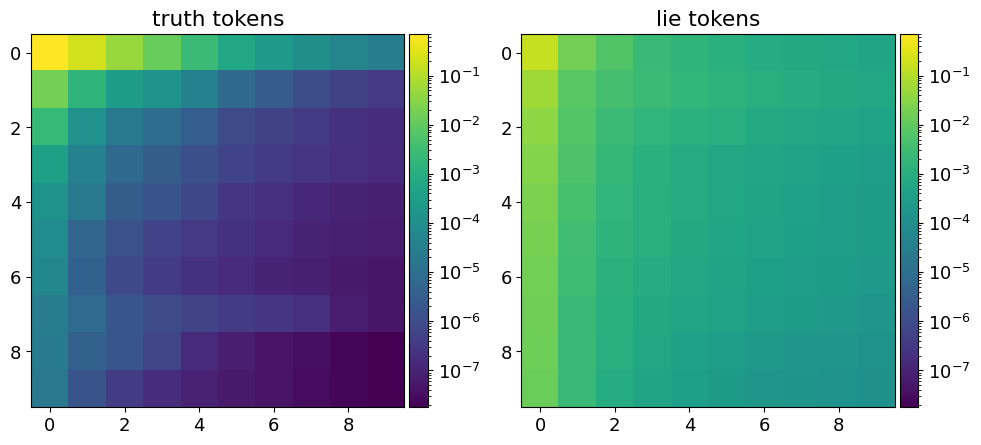

In [ ]:
print(f'captured probability mass truth: {multivariate_truth.sum(dim=(1,2)).mean():.2g}')
print(f'captured probability mass lies: {multivariate_lie.sum(dim=(1,2)).mean():.2g}')

title = f'Multivariate prob. distr. P(Output=(i,j)|Input) {dataset_name}' if titles_in_plots else None
save_path = f'plots/{short_model_name}_{dataset_name}_multivariate_prob_{lens_type}_{format_type}.pdf'
plot_distance_matrix(multivariate_truth.mean(0), multivariate_lie.mean(0), sub_titles=['truth tokens', 'lie tokens'], 
                     sup_title=title, norm=True, remove_diagonal=False, save_path=save_path)


# KL divergence

In [ ]:
dataset['hidden_states_truth'].shape

torch.Size([32, 716, 11, 4096])

In [ ]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='last')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='last')

100%|██████████| 31/31 [00:18<00:00,  1.65it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'KL_truth': KL_truth, 'KL_lie': KL_lie}
    save_path = f'results/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

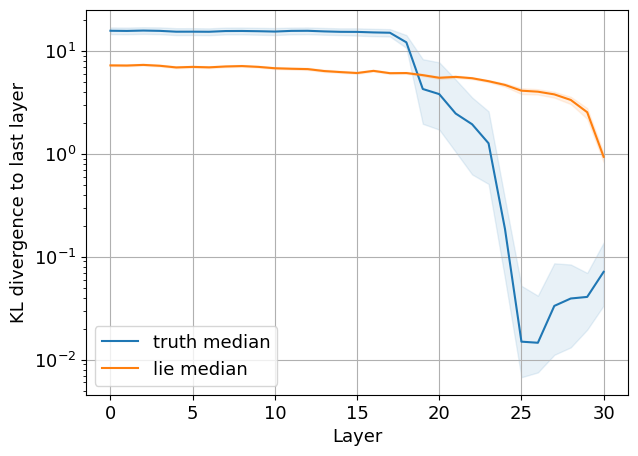

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_{lens_type}_{format_type}.pdf'
title = f'KL divergence {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth, KL_lie, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence to last layer')


In [ ]:
diff = cross_entropy_truth - entropy_truth[:-1]

(diff-KL_truth).abs().max(), (diff-KL_truth).abs().mean()

(tensor(5.7220e-06), tensor(7.8527e-07))

In [ ]:
KL_truth_rate = torch.abs(KL_truth[1:]-KL_truth[:-1])
KL_lie_rate = torch.abs(KL_lie[1:]-KL_lie[:-1])

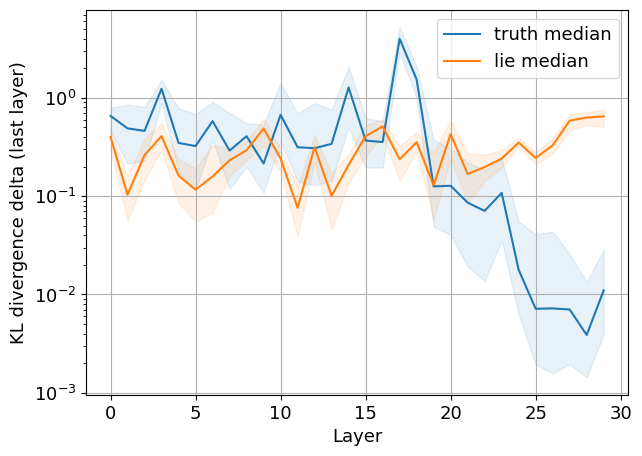

In [ ]:

save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_{lens_type}_{format_type}.pdf'
title = f'KL divergence delta {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_rate, KL_lie_rate, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence delta (last layer)')

In [ ]:
KL_truth_next = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='next')
KL_lie_next = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='next')

100%|██████████| 31/31 [00:19<00:00,  1.63it/s]


In [ ]:
if save_results:
    # save results to file
    results = {'KL_truth_next': KL_truth_next, 'KL_lie_next': KL_lie_next}
    save_path = f'results/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

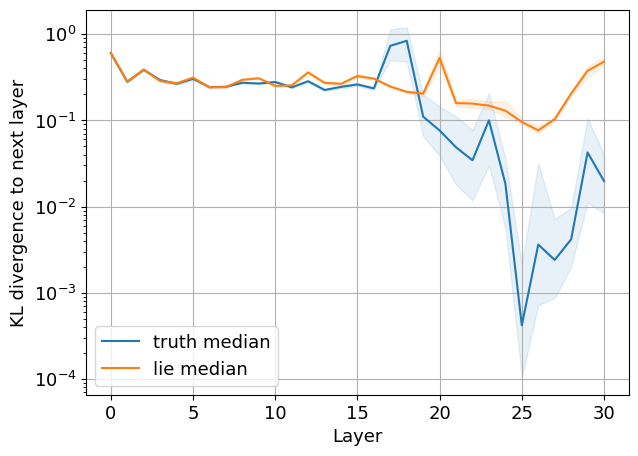

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_next_{lens_type}_{format_type}.pdf'
title = f'KL divergence next layer {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_next, KL_lie_next, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence to next layer')

In [ ]:
KL_truth_rate_next = torch.abs(KL_truth_next[1:]-KL_truth_next[:-1])
KL_lie_rate_next = torch.abs(KL_lie_next[1:]-KL_lie_next[:-1])

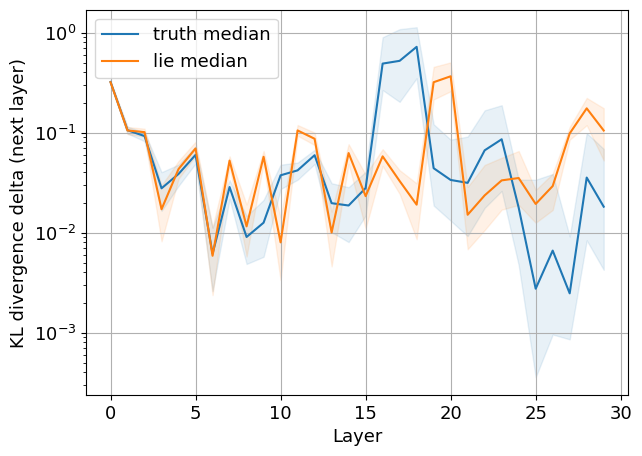

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_KL_rate_next_{lens_type}_{format_type}.pdf'
title = f'KL divergence rate delta next layer {dataset_name}' if titles_in_plots else None
plot_median_mean(KL_truth_rate_next, KL_lie_rate_next, plot_all_curves=False, save_path=save_path, 
                title=title, y_label=f'KL divergence delta (next layer)')

# Similarity of 10 most likely output tokens

In [ ]:
top_k_truth_tokens_embedded = embed(model, top_k_truth_tokens.indices)
top_k_lie_tokens_embedded = embed(model, top_k_lie_tokens.indices)

truth_token_dist = pdist(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_dist = pdist(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

truth_token_sim = pcossim(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_sim = pcossim(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

In [ ]:
if save_results:
    # save results to file
    results = {'truth_token_dist': truth_token_dist, 'lie_token_dist': lie_token_dist,
               'truth_token_sim': truth_token_sim, 'lie_token_sim': lie_token_sim}
    save_path = f'results/{short_model_name}_{dataset_name}_token_dist_sim_{lens_type}_{format_type}.pth'
    torch.save(results, save_path)

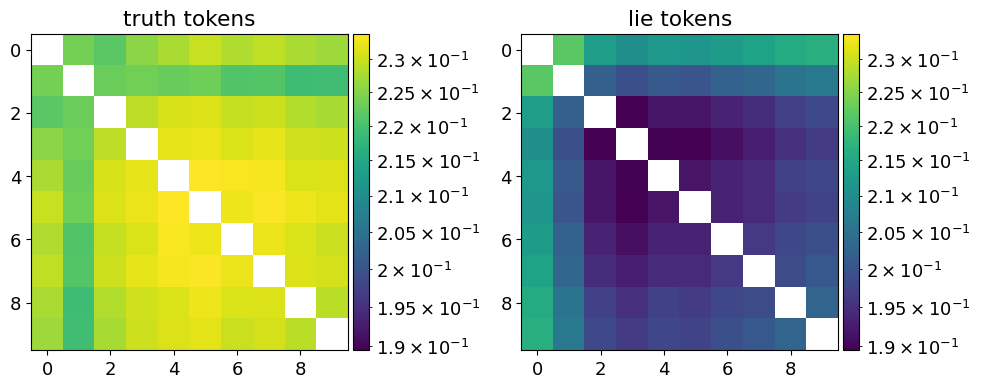

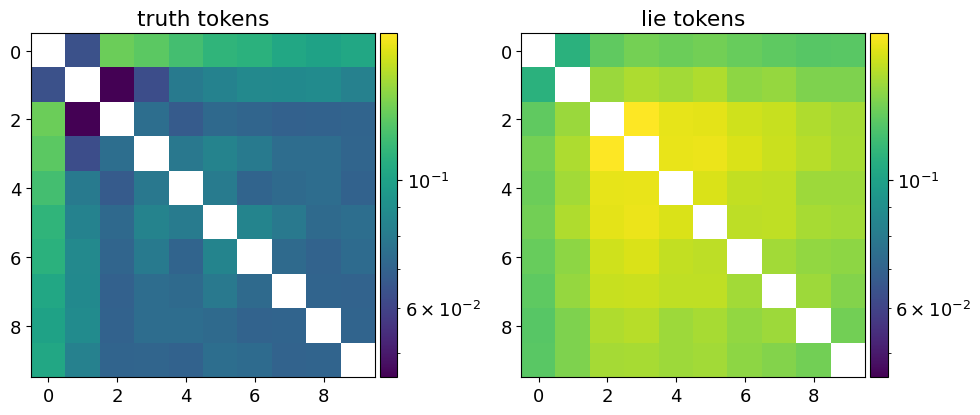

In [ ]:
save_path = f'plots/{short_model_name}_{dataset_name}_token_dist_{lens_type}_{format_type}.pdf'
title = f"{dataset_name} Pairwise eucl. distances of top {k} tokens" if titles_in_plots else None
plot_distance_matrix(truth_token_dist, lie_token_dist, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, save_path=save_path)

save_path = f'plots/{short_model_name}_{dataset_name}_token_sim_{lens_type}_{format_type}.pdf'
title = f"{dataset_name} Pairwise cosine similarity of top {k} tokens" if titles_in_plots else None

plot_distance_matrix(truth_token_sim, lie_token_sim, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=title, norm=True, save_path=save_path)